In [1]:
# import dependencies
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from zipfile import ZipFile
import json
import os.path
import re
import pickle

import data_download

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [2]:
# movies, links, ratings, tags = data_download.load_unprocessed_df(use_large=False)
movies, links, ratings, tags, genome_tags, genome_scores = data_download.load_unprocessed_df(use_large=True)

MovieLens 25M Dataset is downloaded!
MovieLens Latest Small Dataset is downloaded!
MovieLens 25M Dataset is already extracted!
MovieLens Latest Small Dataset is already extracted!


In [4]:
%%time
u_uniq = ratings.userId.unique()
user2idx = {x: i for i, x in enumerate(u_uniq)}
idx2user = {x: x for i, x in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {x: i for i, x in enumerate(m_uniq)}
idx2movie = {x: x for i, x in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

CPU times: user 41.1 s, sys: 1.15 s, total: 42.2 s
Wall time: 42.2 s


In [5]:
num_users = int(ratings.userId.nunique())
num_movies = int(ratings.movieId.nunique())
ratings["rating"] = ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 162541, Number of Movies: 59047, Min rating: 0.5, Max rating: 5.0


In [6]:
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[["userId", "movieId"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [237]:
x_train[:5]

array([[ 99475,   3024],
       [107978,   9645],
       [155371,   1092],
       [ 65224,    227],
       [ 79160,    964]])

In [238]:
y_train[:5]

array([0.66666667, 0.77777778, 0.55555556, 0.77777778, 1.        ])

In [239]:
latent_dim = 10

movie_input = keras.Input(shape=[1], name="movie-input")
movie_embed = layers.Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_flatt = layers.Flatten(name='movie-flatten')(movie_embed)

user_input = keras.Input(shape=[1], name='user-input')
user_embed = layers.Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_flatt = layers.Flatten(name='user-flatten')(user_embed)

concat_layers = layers.Dot(axes=1, name='movie-user-concat')([movie_flatt, user_flatt])
concat_dropou = layers.Dropout(0.2)(concat_layers)

fully_1 = layers.Dense(256, name='fc-1', activation='relu')(concat_dropou)
fully_1_dropout = layers.Dropout(0.2, name='fc-1-dropout')(fully_1)

fully_2 = layers.Dense(128, name='fc-2', activation='relu')(fully_1_dropout)
fully_2_dropout = layers.Dropout(0.2, name='fc-2-dropout')(fully_2)

fully_3 = layers.Dense(1, name='fc-3', activation='relu')(fully_2_dropout)
model = tf.keras.Model([user_input, movie_input], fully_3)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 10)        590480      movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        1625420     user-input[0][0]                 
____________________________________________________________________________________________

In [240]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer=keras.optimizers.Adam(lr=0.001),
)

In [241]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/ckpt',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.0001
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

callbacks = [
    reduce_lr,
    early_stop,
    model_checkpoint_callback
]

In [242]:
history = model.fit(
    x=[x_train[:, 0], x_train[:, 1]],
    y=y_train,
    batch_size=256,
    epochs=10,
    verbose=1,
    callbacks=callbacks,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
)

Train on 22500085 samples, validate on 2500010 samples
Epoch 1/10
22500085/22500085 [==============================] - 975s 43us/sample - loss: 0.0510 - val_loss: 0.0477
Epoch 2/10
22500085/22500085 [==============================] - 973s 43us/sample - loss: 0.0472 - val_loss: 0.0456
Epoch 3/10
22500085/22500085 [==============================] - 973s 43us/sample - loss: 0.0444 - val_loss: 0.0430
Epoch 4/10
22500085/22500085 [==============================] - 974s 43us/sample - loss: 0.0423 - val_loss: 0.0410
Epoch 5/10
22500085/22500085 [==============================] - 974s 43us/sample - loss: 0.0410 - val_loss: 0.0423
Epoch 6/10
22500085/22500085 [==============================] - 973s 43us/sample - loss: 0.0400 - val_loss: 0.0421
Epoch 7/10
22500085/22500085 [==============================] - 974s 43us/sample - loss: 0.0392 - val_loss: 0.0405
Epoch 8/10
22500085/22500085 [==============================] - 974s 43us/sample - loss: 0.0387 - val_loss: 0.0419
Epoch 9/10
22500085/22500

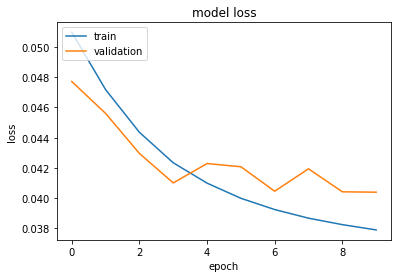

In [243]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [244]:
y_hat = np.round(model.predict([x_val[:, 0], x_val[:, 1]]), decimals=2)
y_true = y_val

In [245]:
mean_absolute_error(y_true, y_hat)

0.1614582089591935

In [248]:
mean_squared_error(y_true, y_hat , squared=False)

0.2009844044156087

In [249]:
model.save("nn_test_1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: nn_test_1/assets


In [7]:
model = keras.models.load_model('nn_test_1')

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
15347762,99475,3024,3.500,1467897440
16647840,107978,9645,4.000,994007728
23915192,155371,1092,3.000,1097887531
10052313,65224,227,4.000,1201382275
12214125,79160,964,5.000,1488915363


In [18]:
def get_movie_rec_for_user(user_id, ratings):
    movies_watched_by_user = ratings[ratings.userId == user_id]
    print("Movies watched by user:")
    print(movies_watched_by_user.head())
    movies_not_watched = movies[
        ~movies["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    print("Movies not watched by user:")
    print(movies_not_watched.head())
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2idx.keys()))
    )
    movies_not_watched = [[movie2idx.get(x)] for x in movies_not_watched]
    print("Movies not watched by user:")
    print(movies_not_watched[:5])
    user_encoder = user2idx.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    print("user_movie_array:")
    print(user_movie_array[:5])
    return
    ratings = model.predict([user_movie_array[:, 0], user_movie_array[:, 1]]).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        idx2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 15)
    print("Movies with high ratings from user")
    print("----" * 15)
    top_movies_user = (
        movies_watched_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId
        .values
    )
    movie_df_rows = movies[movies["movieId"].isin(top_movies_user)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 15)
    print("Top 10 movie recommendations")
    print("----" * 15)
    recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres, "TMDB:", links.loc[links["movieId"] == row.movieId].tmdbId.values)

In [19]:
user_id = ratings.sample(1).iloc[0].userId
user_id

67201.0

In [20]:
get_movie_rec_for_user(user_id, ratings)

Movies watched by user:
          userId  movieId  rating   timestamp
10359973   67201      351   4.000  1489573341
10359950   67201      264   5.000  1489573275
10359959   67201      114   0.500  1489572895
10359976   67201      208   4.500  1489573051
10359958   67201      278   3.000  1489572909
Movies not watched by user:
0    1
1    2
2    3
3    4
4    5
Name: movieId, dtype: int64
Movies not watched by user:
[[29744], [70], [1103], [1017], [4270]]
user_movie_array:
[[67200 29744]
 [67200    70]
 [67200  1103]
 [67200  1017]
 [67200  4270]]
